In [21]:
# Importo librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from collections import Counter


In [22]:
# Correct way to download the raw CSV
!curl -L -o MultiClassDiabetesDataset.csv https://raw.githubusercontent.com/mvera1412/TA136-TB056-TB057-8625/main/data/MulticlassDiabetesDataset.csv
data = pd.read_csv("MultiClassDiabetesDataset.csv")
print(type(data))
print(data.head())
#Class = 0 significa normal, class=1 significa prediabetes,class=2 significa diabetes

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11022  100 11022    0     0  88945      0 --:--:-- --:--:-- --:--:-- 89609
<class 'pandas.core.frame.DataFrame'>
   Gender  AGE  Urea  Cr  HbA1c  Chol   TG  HDL  LDL  VLDL   BMI  Class
0       0   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5  24.0      0
1       1   26   4.5  62    4.9   3.7  1.4  1.1  2.1   0.6  23.0      0
2       1   33   7.1  46    4.9   4.9  1.0  0.8  2.0   0.4  21.0      0
3       0   45   2.3  24    4.0   2.9  1.0  1.0  1.5   0.4  21.0      0
4       0   50   2.0  50    4.0   3.6  1.3  0.9  2.1   0.6  24.0      0


In [23]:
#3. Reportar la cantidad de muestras por clase.
# Diabetes 128 muestras
#Pre diabetes 40 muestras
#Normal 96 Muestras
print(data['Class'].value_counts())

Class
2    128
0     96
1     40
Name: count, dtype: int64


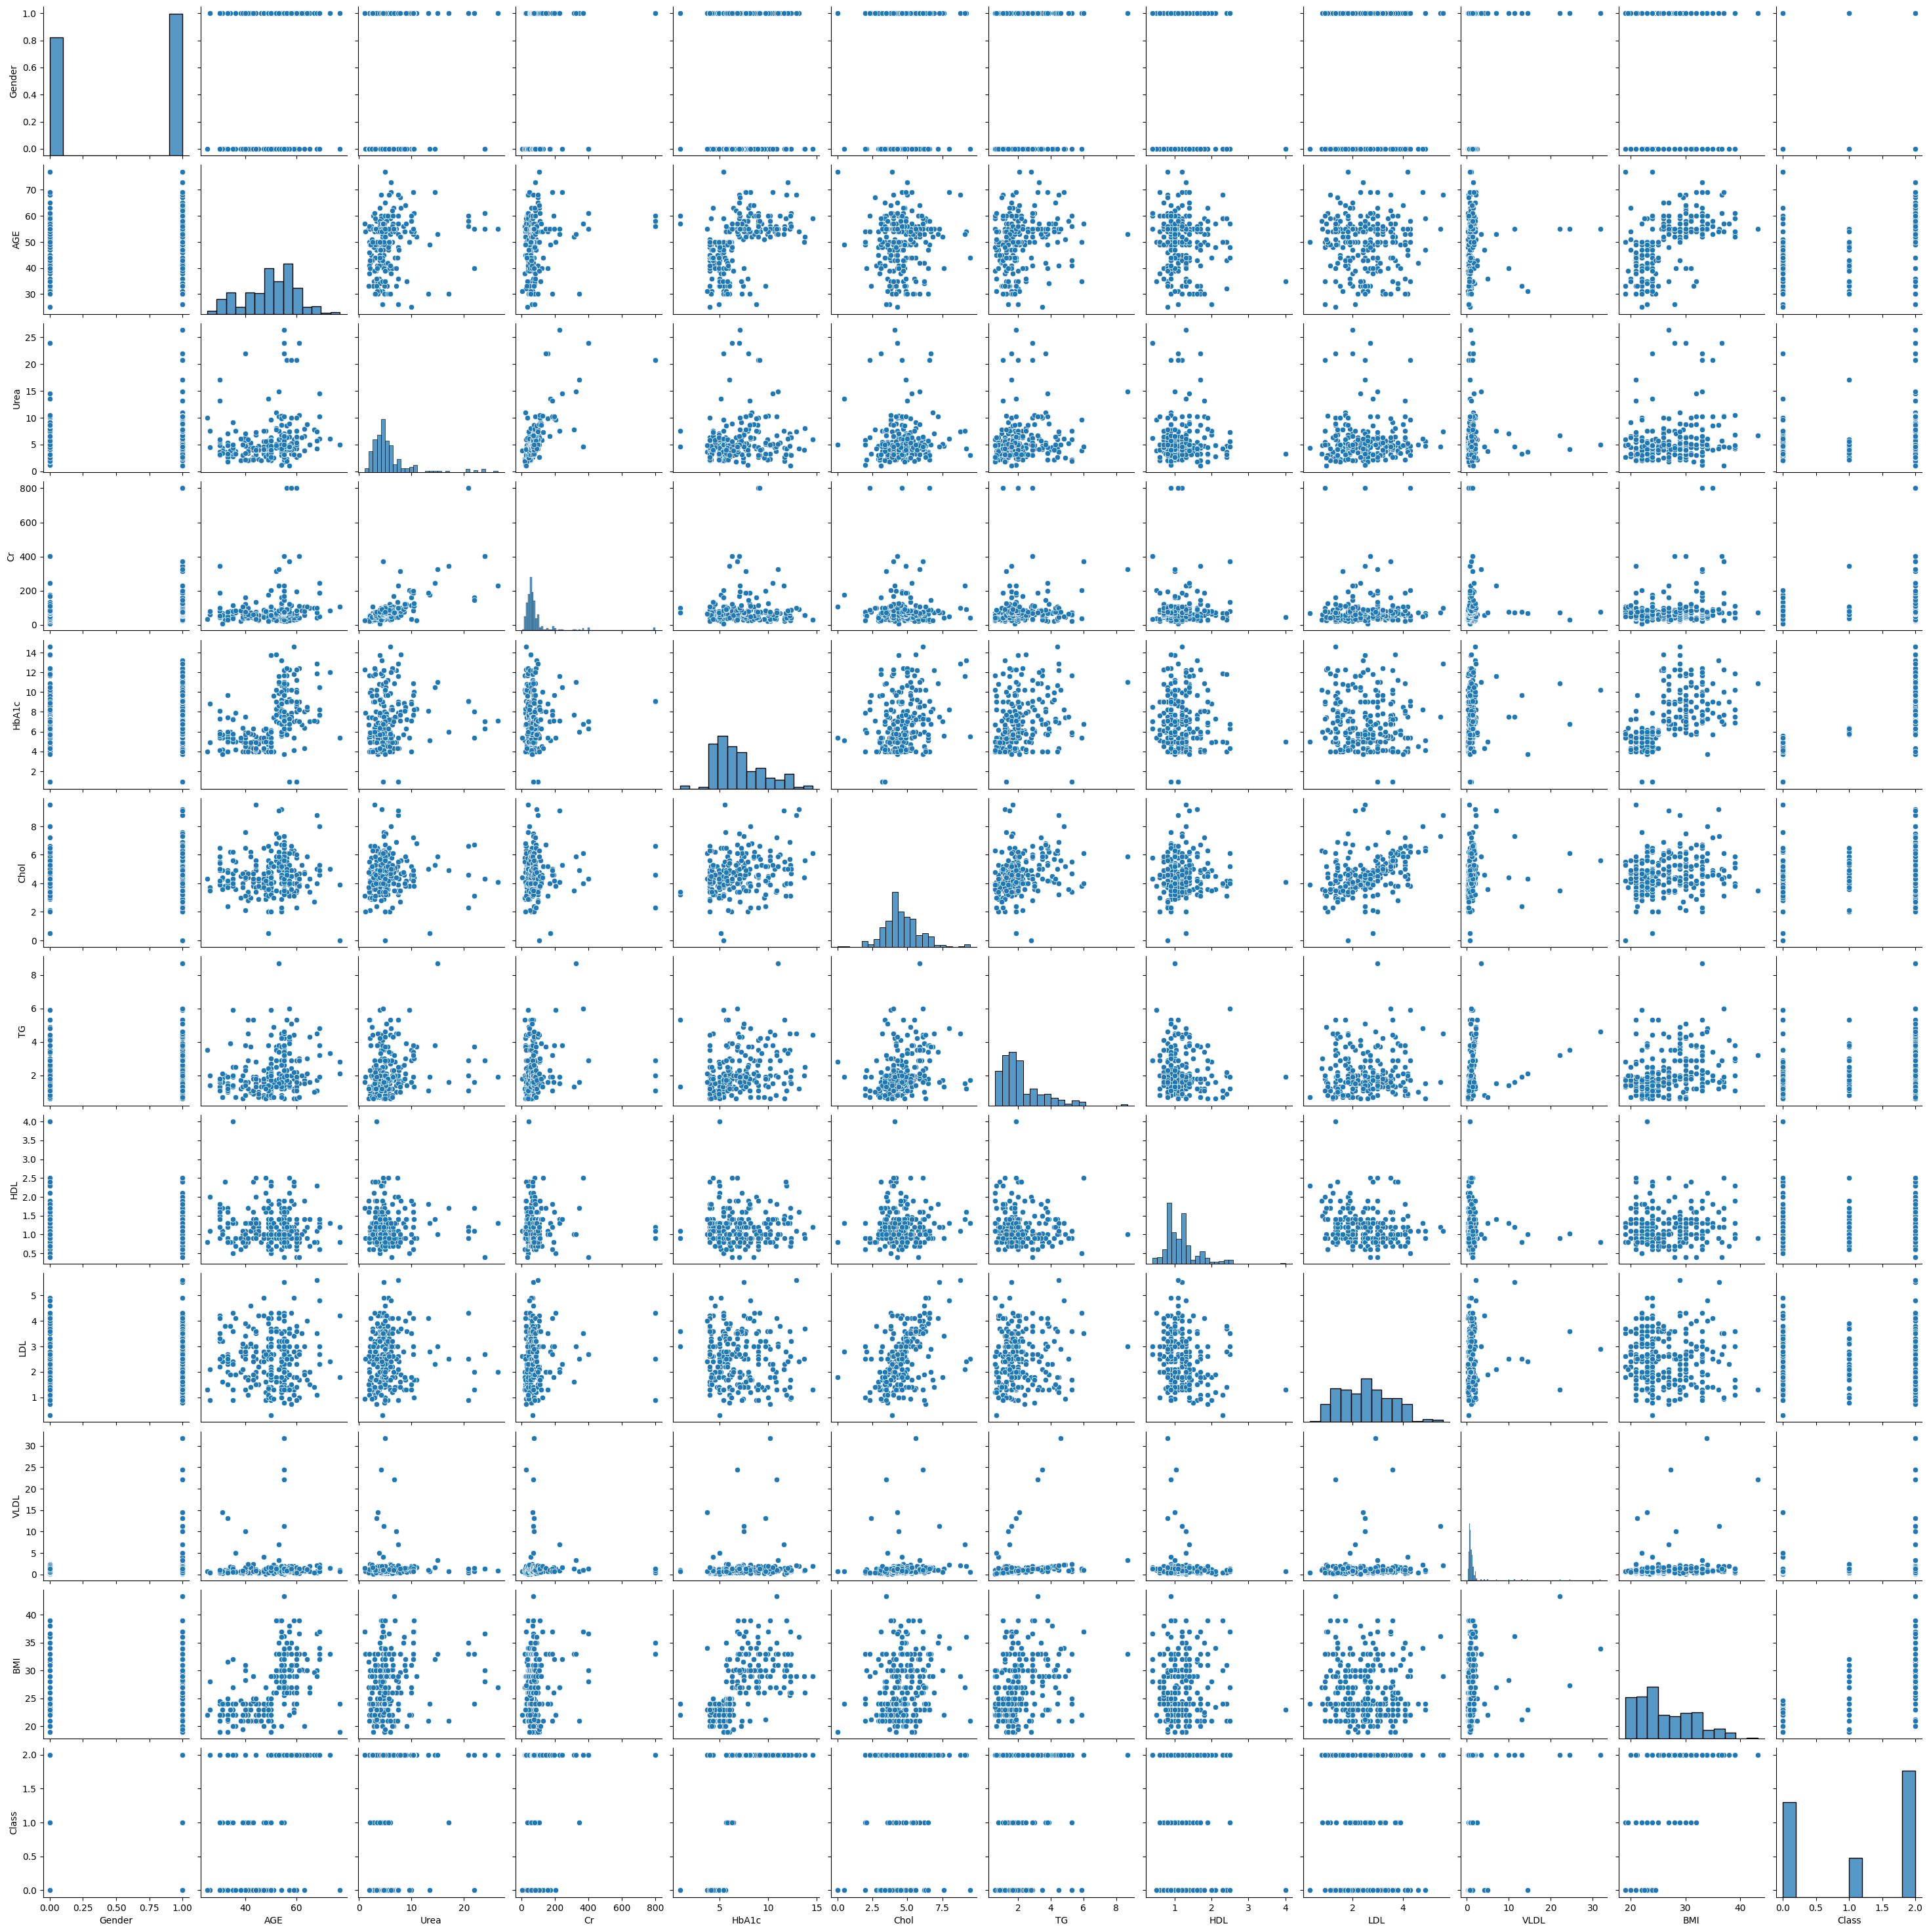

In [24]:
#4. Utilice un pairplot (seaborn). Explicar que significa dicho gr´afico. Justifique por que la caracter´ıstica HbA1c es clave en la clasificaci´on.
sns.pairplot(data)
plt.show()

En el link del dataset de yasserhessein dice que el KbA1c es un indicador clave sobre el nel promedio de glucosa sobre los ultimos 2, 3 meses de la medida.
Comparando los niveles de glucosa para las diferentes casos como se ve en el pairplot te dice que al menos para este dataset cuando las personas son de clase 2, tienen niveles mucho mayores de glucosa que los pre diabeticos y los no diabeticos. Entonces, a priori, parece que va a haber una relacion fuerte entre si una persona es diabetica o no contra sus niveles de glucosa en sangre, tendiendo a pensar que si alguien tiene mas alta glucosa en sangre es mas probable que sea diabetica que si no.

In [25]:
#5. Utilice el comando train_test_split (sklearn) para definir dos conjuntos de datos. El conjunto
#de entrenamiento debe contener el 80 % de las muestras, el resto ser´an de testeo.
y = data['Class']
data = data.drop('Class',axis=1)#Limpio la columna que no voy a estar usando para predecirla
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(data,y,test_size=0.2,random_state=42)

In [26]:
print(f"Tamanio del conj de entrenamiento X {np.shape(X_train)}")
print(f"Tamanio del conj de test X {np.shape(X_test)}")
print(f"Tamanio del conj de entrenamiento y {np.shape(y_train)}")
print(f"Tamanio del conj de test y {np.shape(y_test)}")
###Parece estar bien

Tamanio del conj de entrenamiento X (211, 11)
Tamanio del conj de test X (53, 11)
Tamanio del conj de entrenamiento y (211,)
Tamanio del conj de test y (53,)


##Analisis de discriminante:
1. Implementar una clase LDA_QDA, que funcione para cualquier cantidad de caracterısticas. El codigo
debe estar estructurdo de la siguiente manera.

In [27]:
#Parece que todas las caracteristicas son numericas, nada categorico para predecir el tema diabetes.
#Para eso, parece que voy a tener que agrupar en funcion de la media la distribucion de probabilidad para hacer las predicciones.
#ambas tienen su etapa de entrenamiento a partir de computar estimadores puntuales.
#Para lda uso unicamente la media y para qda ambos, media yvarianza...
##Cuento la cantidad de muestras que pertenecen a mi clase.
#Dk va a ser el subconjunto de las muestras que pertenecen a la clase k
#ck va a ser ese subconjunto dividido el total de muestras (proporcion del subconjunto en la clase k)
#uk media ponderada del feature x por la cantidad de muestras que efectivamente son de la clase k.
#Sigma_k = Desvio de cada una de ellas
#Sigma = Desvio promedio pesado (se asume el mismo para LDA por estimar solo como uk como parametros.)
#La solucion para la funcion discriminante para LDA es = x sigma^-1 uk - 1/2 uk sigma^-1 uk + ln(apriori)
#Para QDA va a ser x sigma^-1 uk - 1/2  + ln(apriori)
#self.params = np.invert(sigma)*
class LDA_QDA:
  # Inicializar atributos y declarar hiperpar´ametros.
  def __init__(self,LDA=False): #LDA selecciona entre LDA y QDA.
    self.lda = LDA
    self.classes = []
    self.ck = {}
    self.uk = {}
    self.sigma_k = {}
    self.sigma = None
  # Etapa de entrenamiento.
  def fit(self,X,y):
    self.classes = np.array(np.unique(y)) #["0","1","2"]
    for k in self.classes:
      Dk = X[y==k] #Conjunto de X que cumplen con que y es la misma cosa
      self.ck[k] = Dk.shape[0]/X.shape[0]
      self.uk[k] = np.mean(Dk,axis=0)
      self.sigma_k[k] = np.atleast_2d(np.cov(Dk,rowvar = False))
    if(self.lda == True):
      self.sigma = sum((X[y==k].shape[0]-1) * self.sigma_k[k] for k in self.classes) / (X.shape[0]-len(self.classes))

  #Alternativa pr´actica para el testeo soft
  def predict_discriminant(self, X):
    X = np.asarray(X)   #
    n_samples = X.shape[0]
    n_classes = len(self.classes)
    scores = np.zeros((n_samples, n_classes))
    epsilon = 1e-6
    for idx, k in enumerate(self.classes):
        mu = np.asarray(self.uk[k]).ravel() #aplana las dimensiones por como estuve haciendo el manejo de Pandas + Numpy, esta desprolijo esto.
        prior = self.ck[k]
        if self.lda:
            sigma_reg = self.sigma + epsilon * np.eye(self.sigma.shape[0]) #Me tiraba error por matriz singular y no se curaba usando la pseudo inversa--> por que?
            sigma_inv = np.linalg.inv(sigma_reg)
            scores[:, idx] = X @ sigma_inv @ mu - 0.5 * mu.T @ sigma_inv @ mu + np.log(prior)
        else:  # QDA
            sigma_reg = self.sigma_k[k] + epsilon * np.eye(self.sigma_k[k].shape[0])
            sigma_inv = np.linalg.inv(sigma_reg)  #Inversa de la matriz
            sign, logdet = np.linalg.slogdet(sigma_reg) #Docs: Calcular el signo y el logaritmo (natural) del determinante de una matriz.
            diff = X - mu
            #quad = np.einsum('ij,jk,ik->i', diff, sigma_inv, diff) #Armo el termino cuadratico, es mas corto que escribir todo el choclo, segun la doc es mas eficiente porque no guarda las matrices temporalmente pero para mi ahorra espacio nomas
            quad = np.sum((diff @ sigma_inv) * diff, axis=1)#Es lo mismo que armar un for y hacer uno por muestra
            scores[:, idx] = -0.5 * quad - 0.5 * logdet + np.log(prior)
    return scores
    #Etapa de testeo soft
  def predict_prob(self, X):
    scores = self.predict_discriminant(X)
    e_x = np.exp(scores - np.max(scores, axis=1, keepdims=True))#Aplico softmax directamente con las fronteras de decision como argumentos.
    return e_x / e_x.sum(axis=1, keepdims=True)
  def predict(self,X):
    scores = self.predict_discriminant(X)
    return self.classes[np.argmax(scores, axis=1)]


In [28]:
#print(X_train['HbA1c'])
#print(lda_model.sigma)
#print(np.linalg.inv(lda_model.sigma))
#print(lda_model.uk[0] + lda_model.sigma)
#print(np.atleast_2d(lda_model.uk[0]@ np.linalg.inv(lda_model.sigma)))
#X = X_train_HbA1c

#print(X @ sigma_inv @ mu)
#print(X_test_HbA1c)
#print(lda_model.sigma)
#print(lda_model.uk.shape)
#print(lda_model.)

In [29]:
#2. Entrenar un clasificador LDA utilizando solamente la caracter´ıstica HbA1c.
####Queda hacerlo###
# Si X_train es DataFrame
X_train_HbA1c = X_train[['HbA1c']]# doble corchete para mantener 2D
X_test_HbA1c = X_test[['HbA1c']]

# Inicializamos el clasificador LDA
lda_model = LDA_QDA(LDA=True)

# Entrenamos solo con HbA1c
lda_model.fit(X_train_HbA1c, y_train)

# Predecimos clases en test
y_pred_lda = lda_model.predict(X_test_HbA1c)

# Probabilidades (opcional)
y_prob_lda = lda_model.predict_prob(X_test_HbA1c)

#print(y_prob_lda)


In [30]:
#Repetir para un clasificador QDA.
####Repeticion####
qda_model = LDA_QDA(LDA=False)

# Entrenamos solo con HbA1c
qda_model.fit(X_train_HbA1c, y_train)

# Predecimos clases en test
y_pred_qda = qda_model.predict(X_test_HbA1c)

# Probabilidades (opcional)
y_prob_qda = qda_model.predict_prob(X_test_HbA1c)

#print(y_prob_qda)

In [31]:
#X = X_train_HbA1c
#sigma_inv = np.atleast_2d(lda_model.sigma)
#mu = lda_model.uk[0]
#prior = lda_model.ck[0]
# print(X.shape)
# print()
# print( X @ np.atleast_2d((sigma_inv @ mu)))
# print(np.atleast_2d(mu.T @ sigma_inv @ mu))
# print(np.atleast_2d((np.log(prior))))
#print(np.array((X @ np.atleast_2d(sigma_inv @ mu) - 0.5 * np.atleast_2d(mu.T @ sigma_inv @ mu) + np.atleast_2d(np.log(prior)))).ravel())

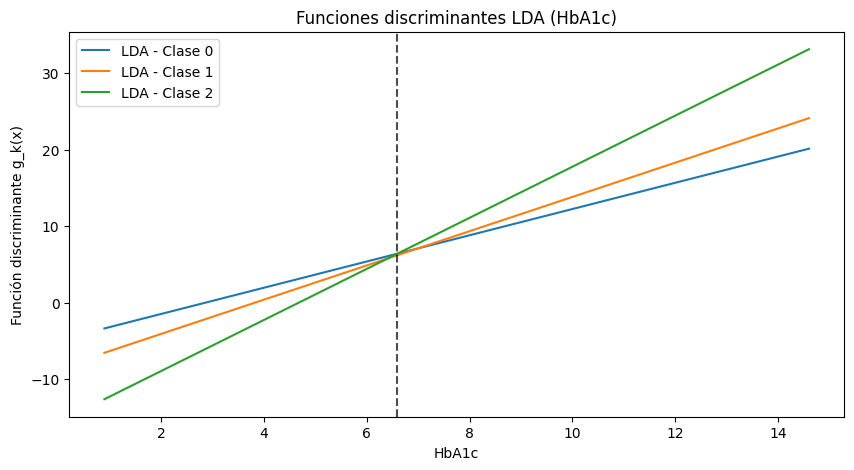

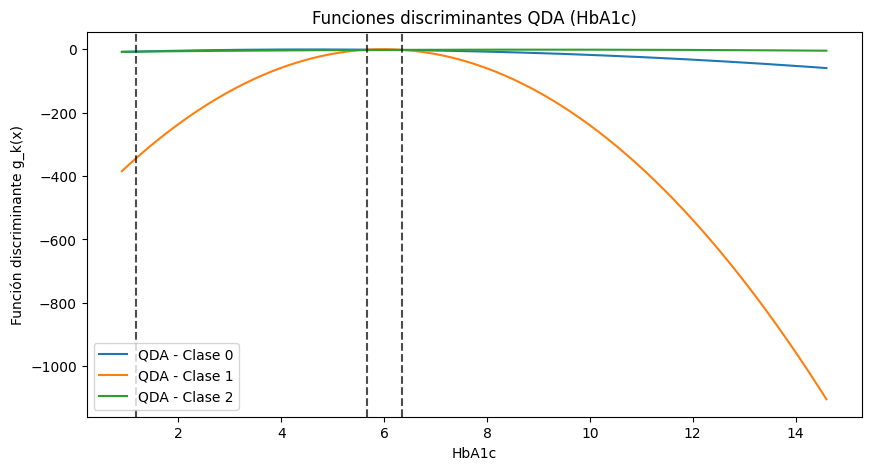

In [32]:
#3. Para cada algoritmo graficar la funci´on discriminante para cada clase e indicar las fronteras de
#decisi´on. Comparar resultados.

# Generar un rango de valores en la escala de HbA1c
x_range = np.linspace(X_train_HbA1c.min().values[0],
                      X_train_HbA1c.max().values[0],
                      300).reshape(-1,1)

# --- LDA ---
scores_lda = lda_model.predict_discriminant(x_range)

plt.figure(figsize=(10,5))
for idx, k in enumerate(lda_model.classes):
    plt.plot(x_range, scores_lda[:,idx], label=f"LDA - Clase {k}")

# Predicciones en el rango
y_pred_range = lda_model.predict(x_range)
boundaries = x_range[np.where(np.diff(y_pred_range) != 0)[0]]

for b in boundaries:
    plt.axvline(b, color="k", linestyle="--", alpha=0.7)

plt.title("Funciones discriminantes LDA (HbA1c)")
plt.xlabel("HbA1c")
plt.ylabel("Función discriminante g_k(x)")
plt.legend()
plt.show()


# --- QDA ---
scores_qda = qda_model.predict_discriminant(x_range)

plt.figure(figsize=(10,5))
for idx, k in enumerate(qda_model.classes):
    plt.plot(x_range, scores_qda[:,idx], label=f"QDA - Clase {k}")

# Predicciones en el rango
y_pred_range = qda_model.predict(x_range)
boundaries = x_range[np.where(np.diff(y_pred_range) != 0)[0]]

for b in boundaries:
    plt.axvline(b, color="k", linestyle="--", alpha=0.7)

plt.title("Funciones discriminantes QDA (HbA1c)")
plt.xlabel("HbA1c")
plt.ylabel("Función discriminante g_k(x)")
plt.legend()
plt.show()

Para LDA se toma para valores un poco mayores a 6 la clase 0 (no tiene diabetes), para QDA toma para valores pequenios la clase 0 sin diabetes, para un pequenio margen pre diabeticos y para valores grandes se decide por diabetes

In [33]:
#4. Reportar accuracy, matriz de confusi´on y macro-F1 utilizando los datos de testeo. ¿Por qu´e dan
#tan diferentes el accuracy y la F1?

# LDA
acc_lda = accuracy_score(y_test, y_pred_lda)
cm_lda = confusion_matrix(y_test, y_pred_lda)
f1_lda = f1_score(y_test, y_pred_lda, average="macro")

print("=== LDA ===")
print("Accuracy:", acc_lda)
print("Matriz de confusión:\n", cm_lda)
print("Macro-F1:", f1_lda)

# QDA
acc_qda = accuracy_score(y_test, y_pred_qda)
cm_qda = confusion_matrix(y_test, y_pred_qda)
f1_qda = f1_score(y_test, y_pred_qda, average="macro")

print("\n=== QDA ===")
print("Accuracy:", acc_qda)
print("Matriz de confusión:\n", cm_qda)
print("Macro-F1:", f1_qda)

=== LDA ===
Accuracy: 0.7924528301886793
Matriz de confusión:
 [[18  0  0]
 [ 8  0  0]
 [ 3  0 24]]
Macro-F1: 0.5690446391322487

=== QDA ===
Accuracy: 0.9245283018867925
Matriz de confusión:
 [[18  0  0]
 [ 0  6  2]
 [ 1  1 25]]
Macro-F1: 0.8996329662996331


El accuracy da relativamente alto para LDA porque hay un desbalance grande de clases (muy pocos prediabeticos, algunos no diabeticos y mayoria diabeticos). Entonces el accuracy da relativamente alto ya que a partir de un cierto nivel siempre se tira a ser diabeticos, el F1 le da mayor prioridad a las clases por mas que sean minoritarias y y no funciona tan bien.
Para QDA funciona mejor gracias a la mayor complejidad de las curvas que mejor describen la frontera de decision.

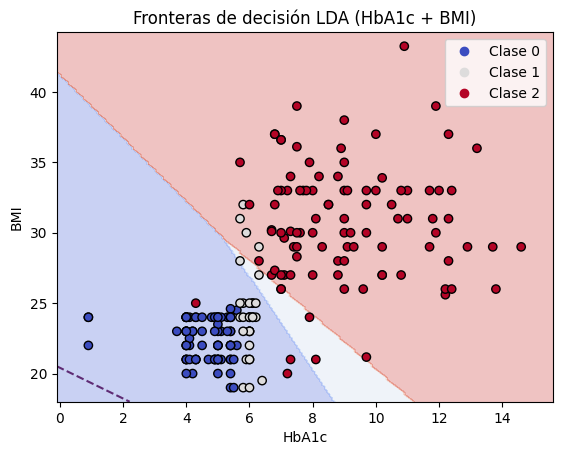

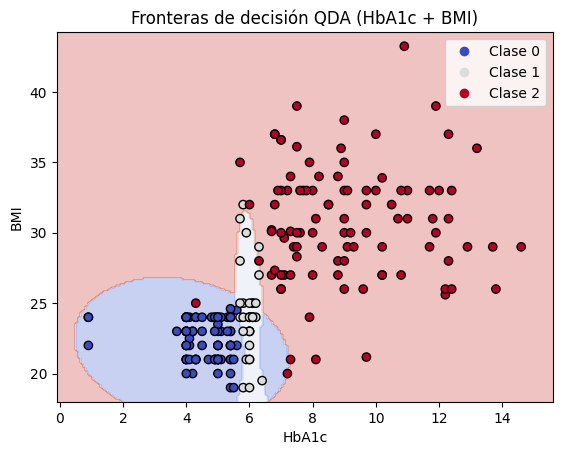

=== LDA ===
Accuracy: 0.8490566037735849
Matriz de confusión:
 [[18  0  0]
 [ 8  0  0]
 [ 0  0 27]]
Macro-F1: 0.6060606060606061

=== QDA ===
Accuracy: 0.9811320754716981
Matriz de confusión:
 [[18  0  0]
 [ 1  7  0]
 [ 0  0 27]]
Macro-F1: 0.9687687687687688


In [34]:

# ==============================
# 2. Entrenar clasificadores
# ==============================
X_train_sel = X_train[['HbA1c','BMI']]
X_test_sel  = X_test[['HbA1c','BMI']]

lda_model = LDA_QDA(LDA=True)
lda_model.fit(X_train_sel, y_train)
y_pred_lda = lda_model.predict(X_test_sel)

qda_model = LDA_QDA(LDA=False)
qda_model.fit(X_train_sel, y_train)
y_pred_qda = qda_model.predict(X_test_sel)

# ==============================
# 3. Funciones discriminantes (gráfico en 2D con curvas de nivel)
# ==============================
def plot_boundaries(model, X, y, title):
    # Crear malla de puntos
    x_min, x_max = X.iloc[:,0].min()-1, X.iloc[:,0].max()+1
    y_min, y_max = X.iloc[:,1].min()-1, X.iloc[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    grid = np.c_[xx.ravel(), yy.ravel()]
    scores = model.predict_discriminant(grid)
    preds = np.argmax(scores, axis=1).reshape(xx.shape)

    # Graficar regiones de decisión
    plt.contourf(xx, yy, preds, alpha=0.3, cmap=plt.cm.coolwarm)

    # Curvas de nivel (fronteras)
    for idx, k in enumerate(model.classes):
        plt.contour(xx, yy, scores[:,idx].reshape(xx.shape),
                    levels=[0], alpha=0.8, linestyles="--")

    # Graficar datos reales
    scatter = plt.scatter(X.iloc[:,0], X.iloc[:,1], c=y, cmap=plt.cm.coolwarm, edgecolor="k")
    plt.xlabel("HbA1c")
    plt.ylabel("BMI")
    plt.title(title)
    plt.legend(handles=scatter.legend_elements()[0],
               labels=[f"Clase {c}" for c in model.classes])
    plt.show()

# LDA
plot_boundaries(lda_model, X_train_sel, y_train, "Fronteras de decisión LDA (HbA1c + BMI)")

# QDA
plot_boundaries(qda_model, X_train_sel, y_train, "Fronteras de decisión QDA (HbA1c + BMI)")

# ==============================
# 4. Métricas
# ==============================
print("=== LDA ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lda))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_lda))
print("Macro-F1:", f1_score(y_test, y_pred_lda, average="macro"))

print("\n=== QDA ===")
print("Accuracy:", accuracy_score(y_test, y_pred_qda))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_qda))
print("Macro-F1:", f1_score(y_test, y_pred_qda, average="macro"))


In [35]:
#6. Repetir los incisos 2. y 4. utilizando todas las caracter´ısticas.


# ==============================
# 2. Entrenar clasificadores
# ==============================
X_train_sel = X_train
X_test_sel  = X_test
print(X_train_sel.shape)
print(y_train.shape)
print(X_test_sel.shape)
lda_model = LDA_QDA(LDA=True)
lda_model.fit(X_train_sel, y_train)
y_pred_lda = lda_model.predict(X_test_sel)

qda_model = LDA_QDA(LDA=False)
qda_model.fit(X_train_sel, y_train)
y_pred_qda = qda_model.predict(X_test_sel)

# ==============================
# 4. Métricas
# ==============================
print("=== LDA ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lda))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_lda))
print("Macro-F1:", f1_score(y_test, y_pred_lda, average="macro"))

print("\n=== QDA ===")
print("Accuracy:", accuracy_score(y_test, y_pred_qda))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_qda))
print("Macro-F1:", f1_score(y_test, y_pred_qda, average="macro"))


(211, 11)
(211,)
(53, 11)
=== LDA ===
Accuracy: 0.8490566037735849
Matriz de confusión:
 [[17  1  0]
 [ 7  1  0]
 [ 0  0 27]]
Macro-F1: 0.6698412698412698

=== QDA ===
Accuracy: 0.9245283018867925
Matriz de confusión:
 [[18  0  0]
 [ 3  5  0]
 [ 0  1 26]]
Macro-F1: 0.8728315709447786


##KNN

Lo unico que hace esta clase es tomar el conjunto de entrenamiento, le calcula distancias a los k vecinos mas cercanos y predice que dicha muestra va a pertencer a la clase mas comun dentro de ese conjunto, como si fuera una votacion entre vecinos.

In [36]:

class KNN:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
    def predict_proba(self, X):
        X = np.array(X)
        probs = []

        for x in X:
            # Distancias a los puntos del entrenamiento
            dists = np.linalg.norm(self.X_train - x, axis=1)
            # Índices de los k vecinos mas cercanos.
            nn_idx = np.argsort(dists)[:self.k]
            nn_labels = self.y_train[nn_idx]
            #Cuenta las clases
            counts = Counter(nn_labels)
            total = sum(counts.values())
            probs.append([counts.get(c, 0) / total for c in np.unique(self.y_train)]) #Las veo como frecuencia relativa.

        return np.array(probs)

    def predict(self, X):
        probs = self.predict_proba(X)
        return np.unique(self.y_train)[np.argmax(probs, axis=1)]




In [37]:
#Entrenarlo
X_train_hba1c = X_train[["HbA1c"]]
X_test_hba1c  = X_test[["HbA1c"]]

knn9 = KNN(k=9)
knn9.fit(X_train_hba1c, y_train)

y_pred_knn = knn9.predict(X_test_hba1c)


Graficos

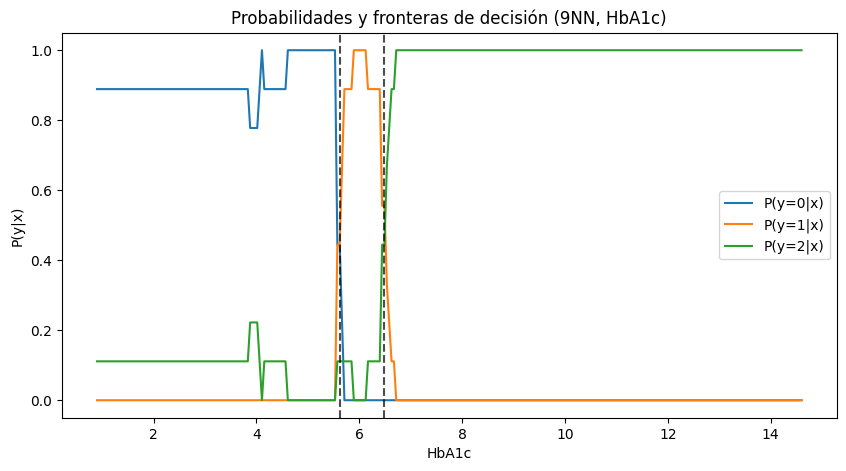

In [38]:

# Rango de valores de HbA1c para graficar
x_range = np.linspace(X_train["HbA1c"].min(), X_train["HbA1c"].max(), 300).reshape(-1,1)

# Probabilidades por clase
probs = knn9.predict_proba(x_range)

plt.figure(figsize=(10,5))
for i, c in enumerate(np.unique(y_train)):
    plt.plot(x_range, probs[:,i], label=f"P(y={c}|x)")

# Fronteras de decisión = donde cambia la clase predicha
y_pred_range = knn9.predict(x_range)
boundaries = x_range[np.where(np.diff(y_pred_range.astype(int)) != 0)[0]]

for b in boundaries:
    plt.axvline(b, color="k", linestyle="--", alpha=0.7)

plt.title("Probabilidades y fronteras de decisión (9NN, HbA1c)")
plt.xlabel("HbA1c")
plt.ylabel("P(y|x)")
plt.legend()
plt.show()


In [39]:

print("=== 9-NN (solo HbA1c) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_knn))
print("Macro-F1:", f1_score(y_test, y_pred_knn, average="macro"))


=== 9-NN (solo HbA1c) ===
Accuracy: 0.9433962264150944
Matriz de confusión:
 [[18  0  0]
 [ 0  8  0]
 [ 1  2 24]]
Macro-F1: 0.934346110816699


Para 2 caraceristicas igual que en QDA, mejora al usar las mas representativas (las que mejor predicen segun el pairplot)

=== 9-NN (HbA1c + BMI) ===
Accuracy: 0.9811320754716981
Matriz de confusión:
 [[18  0  0]
 [ 1  7  0]
 [ 0  0 27]]
Macro-F1: 0.9687687687687688


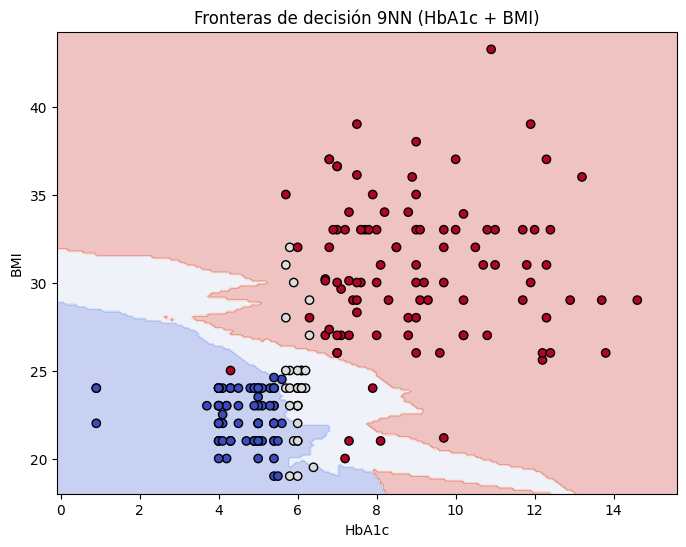

In [40]:
# Selección de 2 características
X_train_2 = X_train[["HbA1c","BMI"]]
X_test_2  = X_test[["HbA1c","BMI"]]

knn9_2d = KNN(k=9)
knn9_2d.fit(X_train_2, y_train)

# Predicciones
y_pred_knn_2d = knn9_2d.predict(X_test_2)

# Métricas
print("=== 9-NN (HbA1c + BMI) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_knn_2d))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_knn_2d))
print("Macro-F1:", f1_score(y_test, y_pred_knn_2d, average="macro"))

# Gráfico de fronteras
x_min, x_max = X_train_2.iloc[:,0].min()-1, X_train_2.iloc[:,0].max()+1
y_min, y_max = X_train_2.iloc[:,1].min()-1, X_train_2.iloc[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

grid = np.c_[xx.ravel(), yy.ravel()]
preds = knn9_2d.predict(grid).reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, preds, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X_train_2.iloc[:,0], X_train_2.iloc[:,1], c=y_train, cmap=plt.cm.coolwarm, edgecolor="k")
plt.xlabel("HbA1c")
plt.ylabel("BMI")
plt.title("Fronteras de decisión 9NN (HbA1c + BMI)")
plt.show()


Tambien como en QDA y en LDA al incorporar todas las features como algunas sin sentido con pocos datos no se pueden encontrar relaciones consistentes, ya que si el conjunto de entrenamiento por casualidad fueron mayoria diabetes y al mismo tiempo mayoria hombres, el modelo va a favorecer la prediccion de diabetes para una muestra que tenga en 1 el feature de si es un hombre.

In [41]:
# Usamos todas las features
X_train_all = X_train
X_test_all  = X_test

knn9_all = KNN(k=9)
knn9_all.fit(X_train_all, y_train)

# Predicciones
y_pred_knn_all = knn9_all.predict(X_test_all)

print("=== 9-NN (todas las características) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_knn_all))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_knn_all))
print("Macro-F1:", f1_score(y_test, y_pred_knn_all, average="macro"))


=== 9-NN (todas las características) ===
Accuracy: 0.8301886792452831
Matriz de confusión:
 [[15  0  3]
 [ 5  3  0]
 [ 1  0 26]]
Macro-F1: 0.7477522477522477
